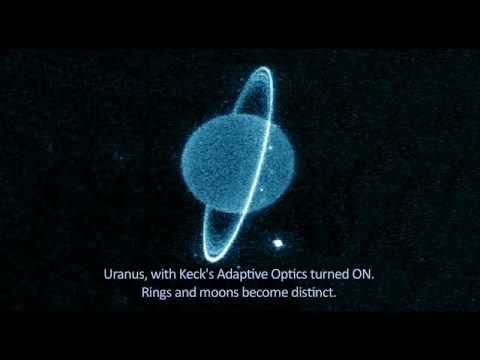

In [1]:
from IPython.display import YouTubeVideo

# Youtube
YouTubeVideo('YVJIolNFzbM',width='600',height='500')

# Import relevant packages
Note: this will not work if you are not running this notebook on your local computer with astroscrappy installed


In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
from scipy.interpolate import RectBivariateSpline
import astroscrappy

# Week 10: Image Reduction
Today we will be reducing images of Uranus taken by Keck Observatory's NIRC2 instrument in 2 filters (Kp, H). Images taken by ground-based telescopes must be calibrated for atmospheric effects, detector artifacts, and cosmic rays in order to be used for science.

Let's start by defining the filepath and variable names.

In [2]:
filt_name = 'kp'
flat_filt = 'kp'
target_name = 'Uranus'
filepath = './data/'

In [3]:
skyf = filepath + 'sky_' + filt_name + '.fits'
uranusf = filepath + target_name + '_' + filt_name + '.fits'
flatf = filepath + 'flat_' + filt_name + '.fits'

Make sure your filepath looks ok

In [4]:
print(uranusf)

./data/Uranus_kp.fits


# All the images which go into one final image:
1. Target image (uranusf) : target in the center of the field of view (in this case, our target is Uranus)

2. Sky image (skyf) : slightly off target, to account for sky artifacts

3. Flat image (flatf) : telescope dome closed and lamp on, to account for detector artifacts

# Fits files
Fits files are the most commonly used data file format in astronomical observations.

In [ ]:
uranus = fits.open(uranusf,ignore_warnings=True,ignore_missing_end=True)

All fits files have a header, which contains information about the data within the fits file, including the date and time of observation, instrument, filter, and many other technical details that may be useful in analysis of the image.

In [ ]:
uranus[0].header

Extract image data from fits file using .data

In [ ]:
uranus_data = uranus[0].data

Do the same for your sky image

In [ ]:
sky = fits.open(skyf,ignore_missing_end=True,ignore_warnings=True)
sky_data = sky[0].data

# Part 1. Apply sky image
Let's plot up the Uranus and sky images to see what they look like

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(uranus_data,origin='lower left',cmap='gnuplot')
plt.title('Uranus Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(sky_data,origin='lower left',cmap='gnuplot')
plt.title('Sky Image')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

They look horrible! This is because NIRC2 observes in the *thermal infrared* (1-5 micron) range, meaning it is essentially recording *heat*. As Keck is a ground-based telescope, Earth's atmosphere is between the detector and our target of interest. Our atmosphere is much warmer than Uranus! In order to remove the thermal detection of our atmosphere, we simply take one image of our target (Uranus), and one image off-target (sky) and simply subtract the sky image from the target image:

In [ ]:
def subtract_sky(image,sky):
    skysub = image - sky
    return skysub

In [ ]:
uranus_skysub = subtract_sky(uranus_data,sky_data)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_skysub,origin='lower left',cmap='gnuplot')
plt.title('After Sky Subtraction')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

Better... but not really!

# Part 2. Flat-fielding
Let's take a look at the flat-field image.

In [ ]:
flat_fits = fits.open(flatf,ignore_warnings=True,ignore_missing_end=True)
flat = flat_fits[0].data
plt.figure(figsize=(8,8))
plt.imshow(flat,origin='lower left',cmap='gnuplot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flat Image')

A 'flat' is an image taken with a constant light source (intensity = 1), so in an ideal world this would be an image where all pixels = 1. Clearly, we are not in an ideal world. In order to account for issues with the detector, we simply scale all pixels by the flat image in order to account for discrepancies in the detector.

In [ ]:
def apply_flat(image,flat):
    with np.errstate(divide='ignore',invalid='ignore'):
        apply_flat = image / flat
    return apply_flat

In [ ]:
uranus_apply_flat = apply_flat(uranus_skysub,flat)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_apply_flat,origin='lower left',cmap='gnuplot')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')
plt.title('After Applying Flat Image')

The image looks worse, but don't panic! Since we are dividing by the flat image where good pixels = 1 and bad pixels ~ 0, bad pixels will be greatly exaggerated.

# Part 3. Removing bad pixels
We can identify and remove bad pixels by creating a "bad pixel map", which will note the location of all pixels whose value are exceptionally different from those of their neighbors.

In [ ]:
def make_badpx_map(flat, outfile, tol, blocksize):
        '''Find pixels whose values are very far from the average of their neighbors
        tol is the fraction different they can be
        blocksize is the number of pixels in each direction over which to average'''
        badpx_map = np.ones(flat.shape)
        for i in range(0,flat.shape[0]+blocksize,blocksize):
            for j in range(0,flat.shape[1]+blocksize,blocksize):
                flatblock = flat[i:i+blocksize,j:j+blocksize]
                mapblock = badpx_map[i:i+blocksize,j:j+blocksize]
                med = np.median(flatblock)
                
                #if not within tolerance, set to NaN
                mapblock[np.where(flatblock/med > 1 + tol)] = 0
                mapblock[np.where(flatblock/med < 1 - tol)] = 0
                badpx_map[i:i+blocksize,j:j+blocksize] = mapblock
        fits.writeto(outfile,data=badpx_map, overwrite=True)

This function creates a "bad pixel map" based on the flat field image, where good pixels = 1 and bad pixels = 0. 

Let's create a bad pixel map for our flat image, which will be saved as 'badpx_kp.fits'

In [ ]:
make_badpx_map(flat=flat,outfile=filepath+'/badpx_'+flat_filt+'.fits',tol = 0.045, blocksize = 4)

In [ ]:
badpx_fits = fits.open(filepath+'badpx_' + flat_filt + '.fits',ignore_missing_end=True)
badpx_map = badpx_fits[0].data

plt.figure(figsize=(8,8))
plt.imshow(badpx_map,origin='lower left',cmap='gnuplot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Bad Pixel Map')

Lots of bad pixels! We can remove them from our image by using a nearest-neighbor smoothing technique.

In [ ]:
def remove_bad_pixels(image,badpx_map):
    bad_indices = np.where(badpx_map == 0)
    smoothed = medfilt(image,kernel_size = 7)
    image[bad_indices] = smoothed[bad_indices]
    return image

In [ ]:
uranus_rm_bp = remove_bad_pixels(uranus_apply_flat,badpx_map)

For all pixels in the image where badpx = 0, the image pixel value will be replaced by the median value of the pixels surrounding it.

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_rm_bp,origin='lower left',cmap='gnuplot')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')
plt.title('After Removing Bad Pixels')

Did a pretty good job, but we know the few negative pixels which remain are not real. We can set these pixel values to 0.

# Part 4. Remove negative pixels

In [ ]:
def negs_to_zero(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] < 0.0:
                image[i,j] = 0.0
    return image

In [ ]:
uranus_nonegs = negs_to_zero(uranus_rm_bp)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_nonegs,origin='lower left',cmap='gnuplot')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')
plt.title('After Removing Negative Pixels')

OK, we're getting somewhere! One final step...

# Part 5. Cosmic Ray Removal
Those few remaining extremely bright pixels are actually real - they are cosmic rays. Cosmic rays are extremely high-energy protons originating from activity on our sun, supernovae explosions, and other high-energy intergalactic events.

We'll use a Python package called *astroscrappy*, which identifies and removes cosmic rays quite nicely.

In [ ]:
def remove_cosmics(image):
    crmask, cleanarr = astroscrappy.detect_cosmics(image, cleantype='medmask')
    image = cleanarr
    return image

In [ ]:
uranus_kp = remove_cosmics(uranus_nonegs)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_kp,origin='lower left',cmap='gnuplot')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')
plt.title('Uranus Kp-Band Final Image')

:O Amazing! Let's save this image as a fits file.

In [ ]:
fits.writeto(filepath+'/uranus_'+flat_filt+'_final.fits',data=uranus_kp, overwrite=True)

Great! We reduced an image. Let's reduce another image of Uranus, this time with a different filter.

We've written functions for each step of the process, all you need to do is call the functions in order to reduce the H band image.

In [ ]:
filt_name = 'h'
flat_filt = 'h'

skyf = filepath + 'sky_' + filt_name + '.fits'
uranusf = filepath + target_name + '_' + filt_name + '.fits'
flatf = filepath + 'flat_' + filt_name + '.fits'

In [ ]:
uranus = fits.open(uranusf,ignore_warnings=True,ignore_missing_end=True)
uranus_data = uranus[0].data
sky = fits.open(skyf,ignore_missing_end=True,ignore_warnings=True)
sky_data = sky[0].data

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(uranus_data,origin='lower left',cmap='gnuplot')
plt.title('Uranus Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(sky_data,origin='lower left',cmap='gnuplot')
plt.title('Sky Image')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

Already looks better than the last one we looked at! Now you just need to go through the same steps to reduce the H band image...

# Part 1. Sky subtraction
<font color=goldenrod>**_Code for you to write_**</font>

Use the ```subtract_sky``` function to subtract ```sky_data``` from ```uranus_data```

In [ ]:
uranus_skysub = ...

Check to see that this worked

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_skysub,origin='lower left',cmap='gnuplot')
plt.title('After Sky Subtraction')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

# Part 2. Flat-fielding
<font color=goldenrod>**_Code for you to write_**</font>

Use the ```apply_flat``` function to scale the target image to the flat field image

In [ ]:
uranus_apply_flat = ...

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_apply_flat,origin='lower left',cmap='gnuplot')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')
plt.title('After Applying Flat Image')

# Part 3. Make and apply bad pixel map
<font color=goldenrod>**_Code for you to write_**</font>

Make a bad pixel map for the H band filter using the ```make_badpx_map``` function, which will output a .fits file called 'badpx_h.fits'

In [ ]:
make_badpx_map(flat = ... ,outfile=filepath+'/badpx_'+flat_filt+'.fits',tol = 0.045, blocksize = 4)

In [ ]:
badpx_fits = fits.open(filepath+'badpx_' + flat_filt + '.fits',ignore_missing_end=True)
badpx_map = badpx_fits[0].data

plt.figure(figsize=(8,8))
plt.imshow(badpx_map,origin='lower left',cmap='gnuplot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Bad Pixel Map')

<font color=goldenrod>**_Code for you to write_**</font>

Remove bad pixels using the ```remove_bad_pixels``` function and the H band bad pixel map

In [ ]:
uranus_rm_bp = ...

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_rm_bp,origin='lower left',cmap='gnuplot')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')
plt.title('After Removing Bad Pixels')

# Part 4. Remove negative pixels
<font color=goldenrod>**_Code for you to write_**</font>

Remove negative pixels using the ```negs_to_zero``` function

In [ ]:
uranus_nonegs = ...

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_nonegs,origin='lower left',cmap='gnuplot')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')
plt.title('After Removing Negative Pixels')

# Part 5. Remove cosmic rays
Final step!

<font color=goldenrod>**_Code for you to write_**</font>


In [ ]:
uranus_h = ...

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_h,origin='lower left',cmap='gnuplot')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')
plt.title('Uranus H-Band Final Image')

Plot the images side by side to see how nice they look

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(uranus_kp,origin='lower left',cmap='gnuplot')
plt.title('Kp band')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(uranus_h,origin='lower left',cmap='gnuplot')
plt.title('H band')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

Amazing!

# Simple cloud pressure analysis
We can use the ratio of the Kp/H band images to find the pressure of clouds in the atmosphere. Let's look at the one bright cloud that is obvious in both images.

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(uranus_kp,origin='lower left',cmap='gnuplot')
ax = plt.gca()
rect = mpatches.Rectangle(xy=(485,555),width=50,height=50,linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.title('Kp band')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(uranus_h,origin='lower left',cmap='gnuplot')
ax = plt.gca()
rect2 = mpatches.Rectangle(xy=(475,550),width=50,height=50,linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect2)
plt.title('H band')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

We can find the pressure of the cloud top using the Kp/H ratio, which can be found by calculating the signal of the cloud in Kp minus the background Kp (noise) over the cloud in H minus the background in H:

kp_h_ratio = (cloud_top_kp - background_kp)/(cloud_top_h - background_h)

Because these images have not been deprojected, the cloud may not be at the same pixel in both images. Let's zoom in on the images and find a good portion to define as "cloud area" and "background" for each image.

<font color=goldenrod>**_Code for you to write_**</font>

Let's assume that the cloud is represented by the *maximum* value in the cloud area in each image, and the background noise is the *median* value of an area in the background sky. Write some code to define variables *cloud_top_kp* and *cloud_top_h* as the maximum pixel value in our selected cloud area, and *backgroud_kp* and *background_h* as the median pixel values in our selected background area.

Calculate *kp_h_ratio* using the equation above.

Use the following graph to estimate pressure of the bright cloud, given your calculated Kp/H ratio. Pressure is in bars.

<img src="data/pressure_graph.png" width = 400 align = 'left'>